# Case study: $CH_{4}$ oxidative coupling


## Task summary

As we discussed before, here I have attached the ‘big’ case study focusing on CH4 oxidative coupling. You can see that this paper has a lot of data and catalysts. You should first check the two references (references 20 and 29) to get the data. As this case study can be challenging, it is okay that you only work on part of the catalyst and data. You can also choose Reference 20 as the case study if that one is easier for you. The papers have used some ML, but there is no much overlap between their work and our thought. We can see in the end if symbolic regression can help us discover some additional physical insight.

 

Once you finish reading the three papers, we can have a quick chat before you work on this case study – you can tell us what you plan to do so that we know it is achievable within the time limit.

In [1]:
#import some useful libraries
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sklearn
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.random import check_random_state
from sympy import *

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Import the Modified OCM Dataset

In [3]:
# Import OCM dataset 
from io import StringIO
OCM = pd.read_csv('https://raw.githubusercontent.com/jimmmmmmmyzzy/Towards-distilling-physical-laws-in-heterogeneous-catalysis-with-symbolic-regression/main/OCM_dataset_modified%20.csv'
                 ,index_col=[0])  
OCM.head()

,Name,M1,M1_atom_number,M2,M2_atom_number,M3,M3_atom_number,Support,Support_ID,M2_mol,M3_mol,M1_mol%,M2_mol%,M3_mol%,Temp,Total_flow,Ar_flow,CH4_flow,O2_flow,CT,CH4/O2,CH4_conv,C2y,C2H6y,C2H4y,COy,CO2y,C2s,C2H6s,C2H4s,COs,CO2s,BET_surface_area,rate_constant,radii_M1,radii_M2,radii_M3,chi_M1,chi_M2,chi_M3
0,Mn-Na2WO4/BN,Mn,25,Na,11,W,74,BN,4,0.37,0.185,40,40,20,900,10,1.5,5.7,2.8,0.75,2,36.28,5.86,0.68,5.18,30.82,6.01,16.15,1.87,14.28,84.95,16.57,5.2,0.080516,1.39,1.66,1.62,1.55,0.93,1.7
1,Mn-Na2WO4/BN,Mn,25,Na,11,W,74,BN,4,0.37,0.185,40,40,20,900,15,2.3,8.5,4.3,0.50,2,37.04,6.29,0.70,5.59,31.29,5.76,16.98,1.89,15.09,84.48,15.55,5.2,0.129931,1.39,1.66,1.62,1.55,0.93,1.7
2,Mn-Na2WO4/BN,Mn,25,Na,11,W,74,BN,4,0.37,0.185,40,40,20,900,20,3.0,11.3,5.7,0.38,2,26.83,5.34,0.55,4.79,21.62,3.12,19.90,2.05,17.85,80.58,11.63,5.2,0.144418,1.39,1.66,1.62,1.55,0.93,1.7
3,Mn-Na2WO4/BN,Mn,25,Na,11,W,74,BN,4,0.37,0.185,40,40,20,900,10,1.5,6.4,2.1,0.75,3,24.47,6.16,0.62,5.54,22.49,3.00,25.17,2.53,22.64,91.91,12.26,5.2,0.084772,1.39,1.66,1.62,1.55,0.93,1.7
4,Mn-Na2WO4/BN,Mn,25,Na,11,W,74,BN,4,0.37,0.185,40,40,20,900,15,2.3,9.6,3.2,0.50,3,24.03,6.54,0.65,5.89,22.34,2.86,27.22,2.70,24.51,92.97,11.90,5.2,0.135273,1.39,1.66,1.62,1.55,0.93,1.7


In [23]:
control = OCM[ (OCM['Total_flow'] == 10) ] #we import all the data points

# Input & Target Variables

In [24]:
frames = [ control.iloc[:,2:3],control.iloc[:,4:5], control.iloc[:,6:], control.iloc[:,15:20], control.iloc[:,20:21], control.iloc[:,32:33], control.iloc[:,33:40]]
result = pd.concat(frames, axis=1)
result.head()

,M1_atom_number,M2_atom_number,M3_atom_number,Support,Support_ID,M2_mol,M3_mol,M1_mol%,M2_mol%,M3_mol%,Temp,Total_flow,Ar_flow,CH4_flow,O2_flow,CT,CH4/O2,CH4_conv,C2y,C2H6y,C2H4y,COy,CO2y,C2s,C2H6s,C2H4s,COs,CO2s,BET_surface_area,rate_constant,radii_M1,radii_M2,radii_M3,chi_M1,chi_M2,chi_M3,Total_flow,Ar_flow,CH4_flow,O2_flow,CT,CH4/O2,BET_surface_area,rate_constant,radii_M1,radii_M2,radii_M3,chi_M1,chi_M2,chi_M3
0,25,11,74,BN,4,0.37,0.185,40,40,20,900,10,1.5,5.7,2.8,0.75,2,36.28,5.86,0.68,5.18,30.82,6.01,16.15,1.87,14.28,84.95,16.57,5.2,0.080516,1.39,1.66,1.62,1.55,0.93,1.7,10,1.5,5.7,2.8,0.75,2,5.2,0.080516,1.39,1.66,1.62,1.55,0.93,1.7
3,25,11,74,BN,4,0.37,0.185,40,40,20,900,10,1.5,6.4,2.1,0.75,3,24.47,6.16,0.62,5.54,22.49,3.00,25.17,2.53,22.64,91.91,12.26,5.2,0.084772,1.39,1.66,1.62,1.55,0.93,1.7,10,1.5,6.4,2.1,0.75,3,5.2,0.084772,1.39,1.66,1.62,1.55,0.93,1.7
6,25,11,74,BN,4,0.37,0.185,40,40,20,900,10,1.5,6.8,1.7,0.75,4,18.44,6.06,0.56,5.50,17.03,1.84,32.86,3.04,29.83,92.35,9.98,5.2,0.083352,1.39,1.66,1.62,1.55,0.93,1.7,10,1.5,6.8,1.7,0.75,4,5.2,0.083352,1.39,1.66,1.62,1.55,0.93,1.7
9,25,11,74,BN,4,0.37,0.185,40,40,20,900,10,1.5,7.3,1.2,0.75,6,18.40,5.63,0.56,5.07,11.85,0.92,30.60,3.04,27.55,64.40,5.00,5.2,0.077263,1.39,1.66,1.62,1.55,0.93,1.7,10,1.5,7.3,1.2,0.75,6,5.2,0.077263,1.39,1.66,1.62,1.55,0.93,1.7
12,25,11,74,BN,4,0.37,0.185,40,40,20,900,10,4.0,4.0,2.0,0.75,2,37.29,5.66,0.68,4.98,32.66,5.38,15.18,1.82,13.35,87.58,14.43,5.2,0.077687,1.39,1.66,1.62,1.55,0.93,1.7,10,4.0,4.0,2.0,0.75,2,5.2,0.077687,1.39,1.66,1.62,1.55,0.93,1.7


In [25]:
result = control[control.loc[:]!=0].dropna()

In [26]:
result.head()

,Name,M1,M1_atom_number,M2,M2_atom_number,M3,M3_atom_number,Support,Support_ID,M2_mol,M3_mol,M1_mol%,M2_mol%,M3_mol%,Temp,Total_flow,Ar_flow,CH4_flow,O2_flow,CT,CH4/O2,CH4_conv,C2y,C2H6y,C2H4y,COy,CO2y,C2s,C2H6s,C2H4s,COs,CO2s,BET_surface_area,rate_constant,radii_M1,radii_M2,radii_M3,chi_M1,chi_M2,chi_M3
0,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,10,1.5,5.7,2.8,0.75,2,36.28,5.86,0.68,5.18,30.82,6.01,16.15,1.87,14.28,84.95,16.57,5.2,0.080516,1.39,1.66,1.62,1.55,0.93,1.7
3,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,10,1.5,6.4,2.1,0.75,3,24.47,6.16,0.62,5.54,22.49,3.00,25.17,2.53,22.64,91.91,12.26,5.2,0.084772,1.39,1.66,1.62,1.55,0.93,1.7
6,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,10,1.5,6.8,1.7,0.75,4,18.44,6.06,0.56,5.50,17.03,1.84,32.86,3.04,29.83,92.35,9.98,5.2,0.083352,1.39,1.66,1.62,1.55,0.93,1.7
9,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,10,1.5,7.3,1.2,0.75,6,18.40,5.63,0.56,5.07,11.85,0.92,30.60,3.04,27.55,64.40,5.00,5.2,0.077263,1.39,1.66,1.62,1.55,0.93,1.7
12,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,10,4.0,4.0,2.0,0.75,2,37.29,5.66,0.68,4.98,32.66,5.38,15.18,1.82,13.35,87.58,14.43,5.2,0.077687,1.39,1.66,1.62,1.55,0.93,1.7


In [27]:
result.shape

(2733, 40)

In [34]:
#X_raw = result[["M1_atom_number", "M2_atom_number", "M3_atom_number", "BET_surface_area", "Temp", "Ar_flow", "CH4_flow", "O2_flow", "CH4/O2", "M1_mol%", "M2_mol%", "M3_mol%", "radii_M1", "radii_M2", "radii_M3", "chi_M1", "chi_M2", "chi_M3" ]]
X_raw = result[["CH4_flow", "O2_flow", "Ar_flow", "Temp", "CH4/O2", "BET_surface_area", "M1_mol%", "M2_mol%", "M3_mol%", "M1_atom_number", "M2_atom_number", "M3_atom_number", "radii_M1", "radii_M2", "radii_M3", "chi_M1", "chi_M2", "chi_M3" ]]
X_raw.describe()



,CH4_flow,O2_flow,Ar_flow,Temp,CH4/O2,BET_surface_area,M1_mol%,M2_mol%,M3_mol%,M1_atom_number,M2_atom_number,M3_atom_number,radii_M1,radii_M2,radii_M3,chi_M1,chi_M2,chi_M3
count,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000
mean,4.491218,1.350457,4.166667,795.901939,3.748262,489.442371,40.263447,39.604830,20.131723,30.901207,14.052689,69.796561,1.471405,1.655488,1.609491,1.567387,0.980842,1.760424
std,1.779373,0.669185,2.248868,65.214764,1.478841,267.903422,1.601875,2.402812,0.800937,11.978160,9.355873,10.811287,0.211750,0.182492,0.027028,0.230404,0.192803,0.155412
min,2.000000,0.400000,1.500000,700.000000,2.000000,1.500000,40.000000,25.000000,20.000000,22.000000,3.000000,42.000000,1.220000,1.220000,1.540000,1.100000,0.820000,1.700000
25%,2.400000,0.900000,1.500000,750.000000,2.000000,300.000000,40.000000,40.000000,20.000000,25.000000,11.000000,74.000000,1.390000,1.660000,1.620000,1.550000,0.930000,1.700000
50%,4.500000,1.200000,4.000000,800.000000,3.000000,650.000000,40.000000,40.000000,20.000000,25.000000,11.000000,74.000000,1.390000,1.660000,1.620000,1.550000,0.930000,1.700000
75%,5.700000,2.000000,7.000000,850.000000,4.000000,650.000000,40.000000,40.000000,20.000000,29.000000,11.000000,74.000000,1.390000,1.660000,1.620000,1.550000,0.930000,1.700000
max,7.300000,2.800000,7.000000,900.000000,6.000000,650.000000,50.000000,40.000000,25.000000,72.000000,56.000000,74.000000,2.070000,2.150000,1.620000,2.200000,1.830000,2.160000


In [35]:
y = result["rate_constant"]
y.describe()


count    2733.000000
mean        0.086693
std         0.051980
min         0.004006
25%         0.052486
50%         0.077828
75%         0.109872
max         0.301364
Name: rate_constant, dtype: float64

(array([392., 587., 759., 460., 212., 145.,  95.,  51.,  26.,   6.]),
 array([0.00400601, 0.03374177, 0.06347753, 0.09321329, 0.12294904,
        0.1526848 , 0.18242056, 0.21215632, 0.24189207, 0.27162783,
        0.30136359]),
 <BarContainer object of 10 artists>)

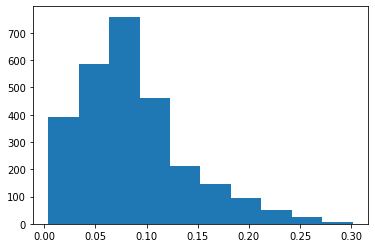

In [36]:
plt.hist(y)

# Correlation Analysis

<AxesSubplot:>

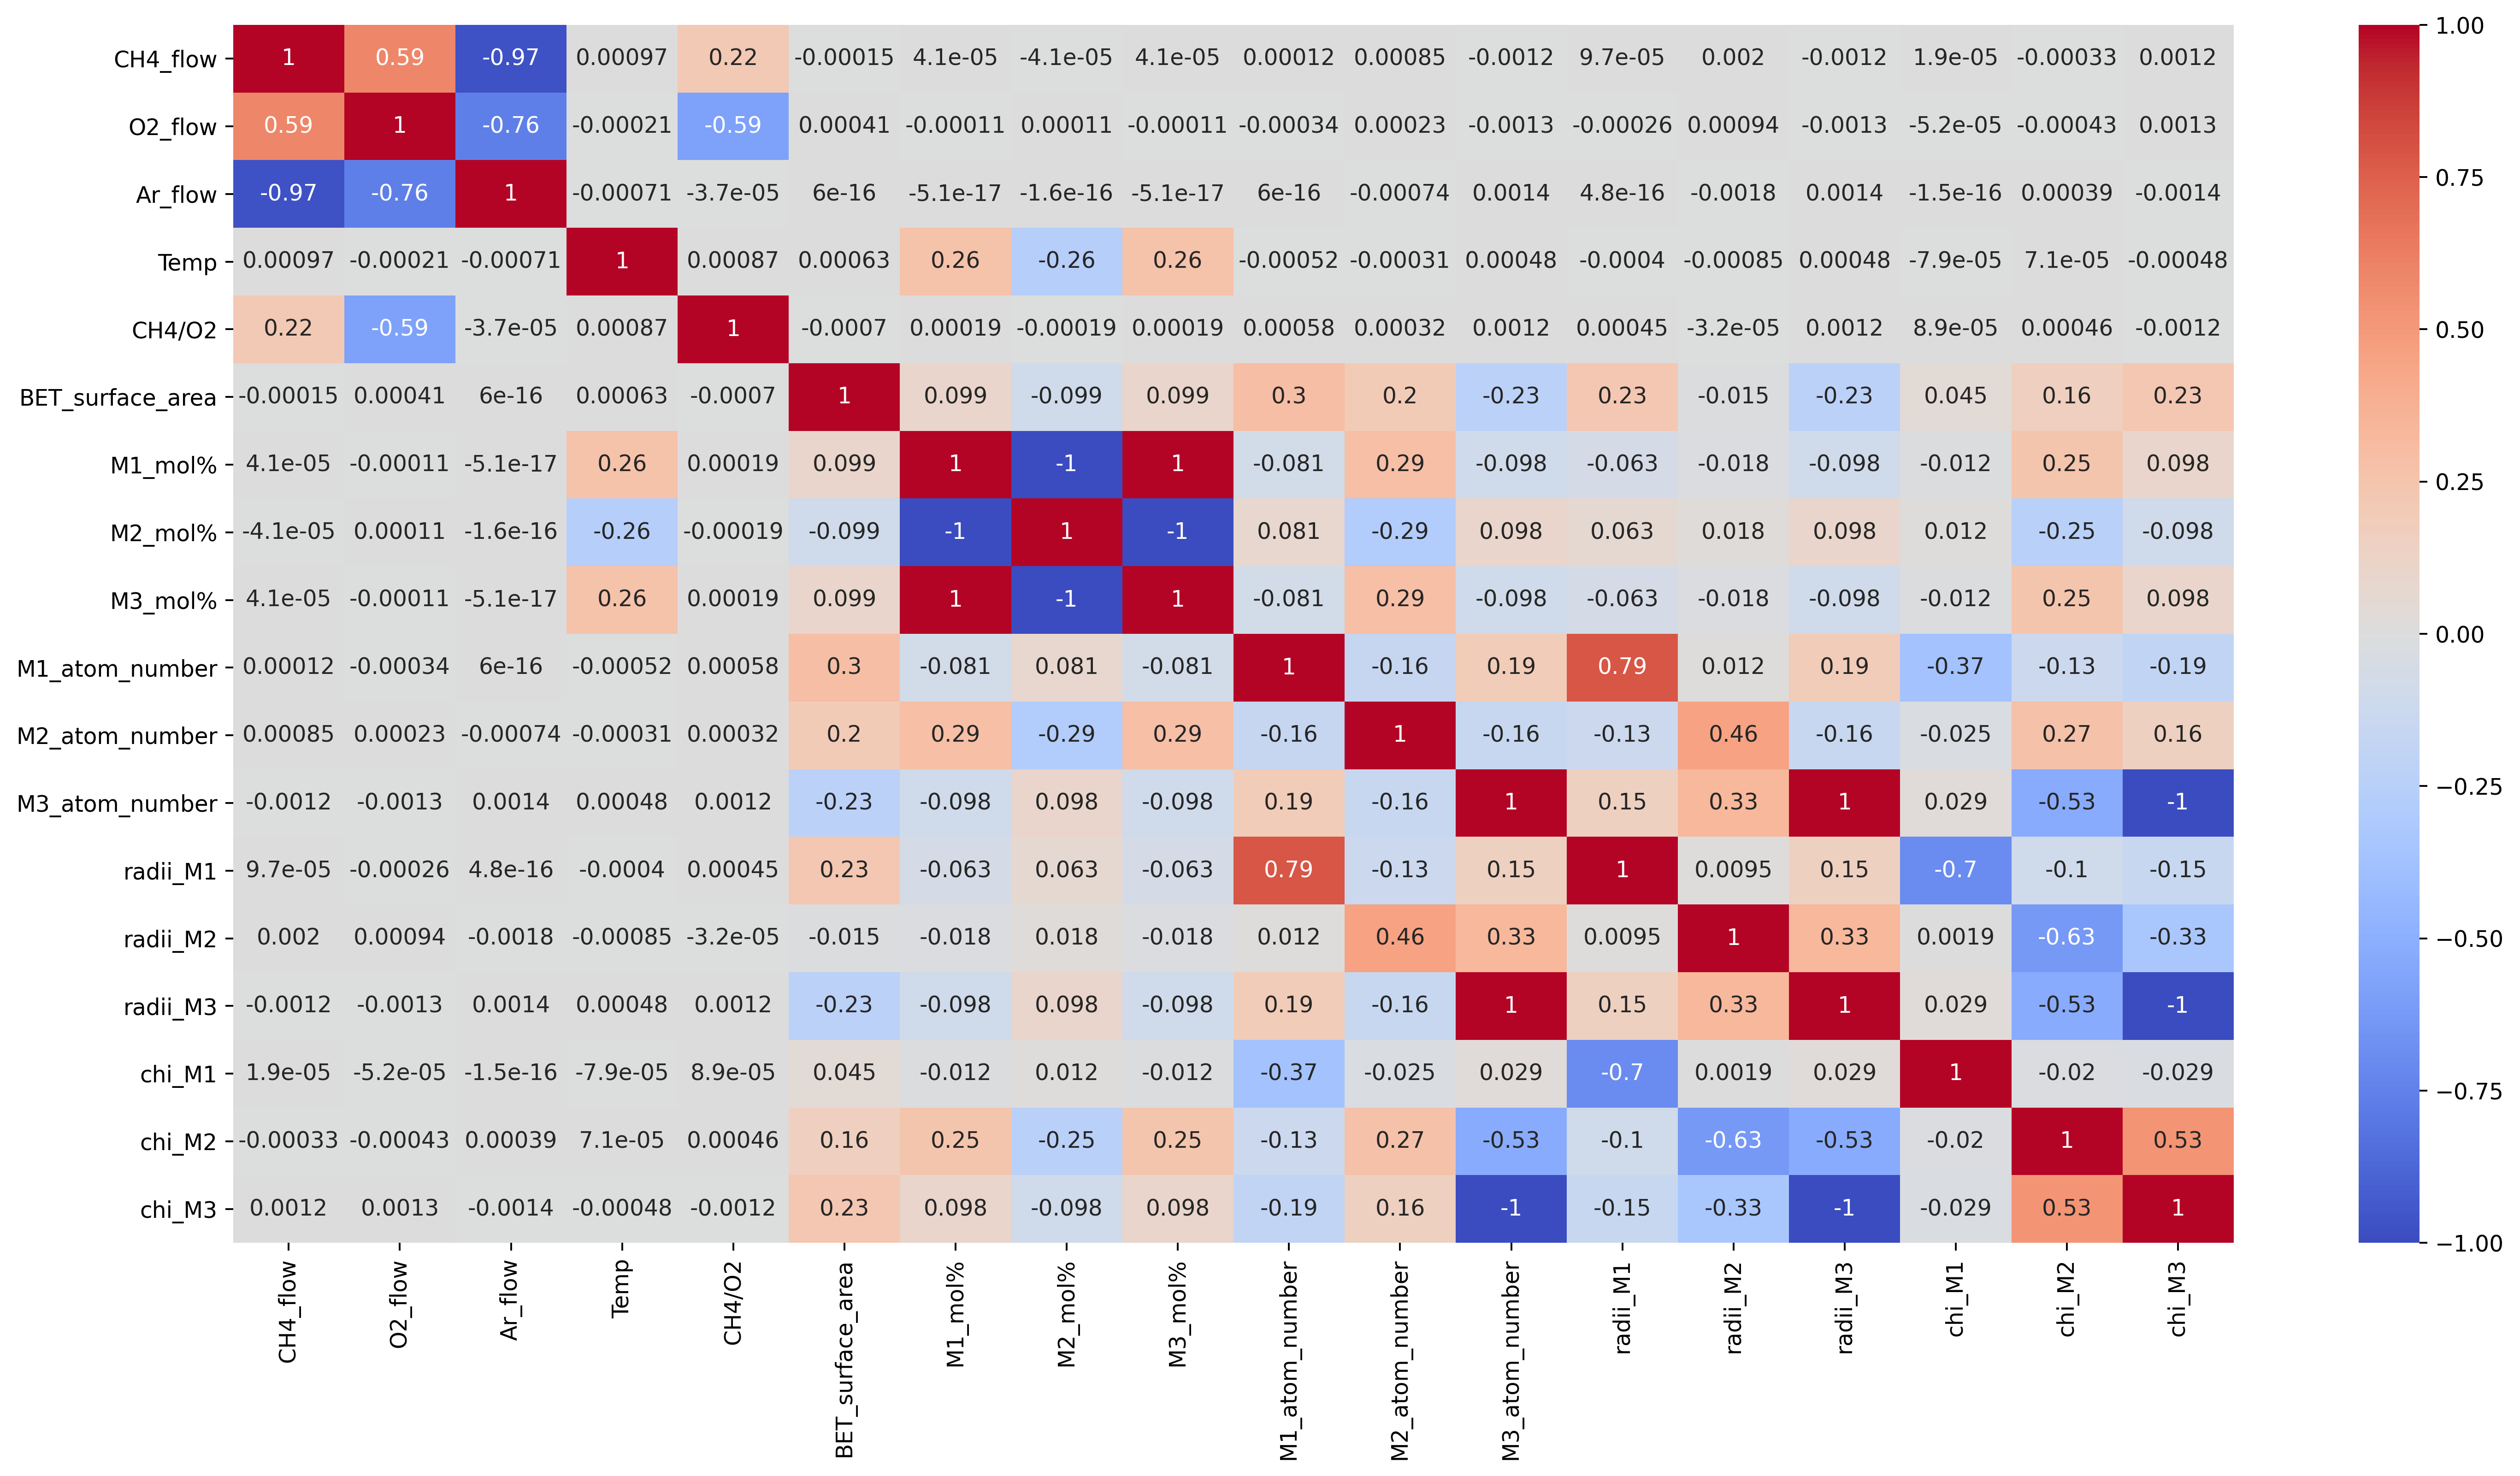

In [37]:
#Idenitfy corelated independent variables through heatmap
import seaborn as sb
corrmat = X_raw.corr()
plt.figure(figsize=(20,10), dpi =350)
sb.heatmap(corrmat, cmap = "coolwarm", annot=True)


<Figure size 2100x1400 with 0 Axes>

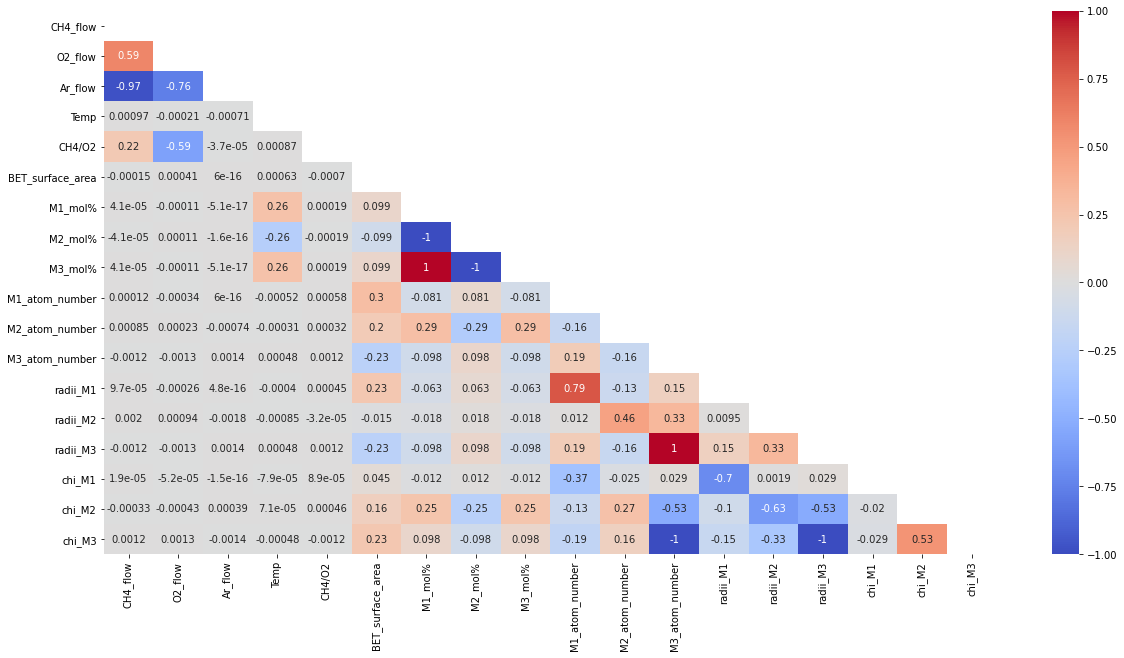

<Figure size 2100x1400 with 0 Axes>

In [38]:
corrmat = X_raw.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corrmat)
plt.figure(figsize=(20,10))
# using the upper triangle matrix as mask 
sns.heatmap(corrmat, cmap = "coolwarm", annot=True, mask=matrix)
plt.figure(dpi=350)

# Multiariate Analytics (Dimensionality Reduction & Feature Selection)

In [14]:
import pyphi as phi
import pyphi_plots as pp

In [13]:
#we first begin with 4 PCs
pcaobj = phi.pca( X_raw, 7, mcs=True,
                 md_algorithm='nipals', force_nipals=False, 
                 shush=False, cross_val=5)
#N.B. stoppping criterion: when eigen value is smaller than 1

Cross validating PC #1
Cross validating PC #2
Cross validating PC #3
Cross validating PC #4
Cross validating PC #5
Cross validating PC #6
Cross validating PC #7
phi.pca using NIPALS and cross validation (5%) executed on: 2022-08-21 16:01:14.342158
--------------------------------------------------------------
PC #          Eig      R2X     sum(R2X)      Q2X     sum(Q2X)
PC #1:      3.758    0.269     0.269       0.220     0.220
PC #2:      2.287    0.163     0.432       0.143     0.363
PC #3:      1.688    0.121     0.553       0.083     0.447
PC #4:      1.501    0.107     0.660       0.100     0.546
PC #5:      1.428    0.102     0.762       -0.652     -0.106
PC #6:      1.006    0.072     0.834       0.890     0.785
PC #7:      0.868    0.062     0.896       0.079     0.864
--------------------------------------------------------------


In [15]:
#we first begin with 4 PCs
pcaobj = phi.pca(X_raw, 6, mcs=True,
                 md_algorithm='nipals', force_nipals=False, 
                 shush=False, cross_val=0)
#N.B. stoppping criterion: when eigen value is smaller than 1

phi.pca using SVD executed on: 2022-08-21 16:01:59.711394
--------------------------------------------------------------
PC #      Eig        R2X       sum(R2X) 
PC #1:      3.758    0.269     0.269
PC #2:      2.287    0.163     0.432
PC #3:      1.688    0.121     0.553
PC #4:      1.501    0.107     0.660
PC #5:      1.428    0.102     0.762
PC #6:      1.006    0.072     0.834
--------------------------------------------------------------


In [16]:
pp.loadings_map(pcaobj,[1,2])

In [17]:
pp.r2pv(pcaobj)
pp.figure

<function bokeh.plotting.figure.figure(**kwargs)>

In [24]:
#pp.loadings(pcaobj,plotwidth=400
pp.score_scatter(pcaobj,[1,2], CLASSID = result, colorby= "Support ",add_ci=True, add_legend=True, plotwidth=650)
#pp.score_scatter(pcaobj,[1,3],plotwidth=1200)

In [21]:
#pp.loadings(pcaobj,plotwidth=400
pp.score_line(pcaobj,5, CLASSID = X_raw, colorby= "O2_flow",add_ci=True, add_legend=True, plotwidth=650)
#pp.score_scatter(pcaobj,[1,3],plotwidth=1200)

In [42]:
#pp.loadings(pcaobj,plotwidth=400
pp.score_scatter(pcaobj,[1,2], CLASSID = X_raw, colorby= "BET_surface_area",add_ci=True, add_labels=True, add_legend=True, plotwidth=650)
#pp.score_scatter(pcaobj,[1,3],plotwidth=1200)

In [25]:
pp.score_scatter(pcaobj,[1,2])

In [175]:
pp.diagnostics(pcaobj)

In [37]:
pp.contributions_plot(pcaobj,X_raw,'spe',to_obs=3711)

In [ ]:
add_ci=False, add_labels=False, add_legend=Tru

In [38]:
pp.score_scatter(pcaobj,[1,2], add_ci=True, add_labels=True, add_legend=True)

In [39]:
pp.weighted_loadings(pcaobj)

In [39]:
#PLS
import pyphi as phi
import pyphi_plots as pp

# Load the data from Excel
condition   = X_raw
rate_constant = y.to_numpy().reshape(-1,1)

#clean data


# Build model
plsobj=phi.pls(condition,rate_constant,5,cross_val=5)


Cross validating LV #1
Cross validating LV #2
Cross validating LV #3
Cross validating LV #4
Cross validating LV #5
phi.pls using NIPALS and cross-validation (5%) executed on: 2022-08-24 18:24:24.807248
---------------------------------------------------------------------------------
PC #       Eig      R2X     sum(R2X)      R2Y     sum(R2Y)      Q2Y     sum(Q2Y)
PC #1:   2.970    0.215     0.215       0.041     0.041       0.038     0.038
PC #2:   1.351    0.091     0.307       0.021     0.063       0.020     0.058
PC #3:   1.696    0.132     0.439       0.003     0.065       0.002     0.060
PC #4:   1.045    0.099     0.538       0.001     0.066       0.002     0.062
PC #5:   0.502    0.077     0.615       0.002     0.068       -0.002     0.060
---------------------------------------------------------------------------------


In [40]:
condition,columns_removed_y = phi.clean_low_variances(condition)

# Build model
plsobj=phi.pls(condition ,rate_constant,4,cross_val=0)

#pp.r2pv(plsobj)

phi.pls using SVD executed on: 2022-08-24 18:24:29.330435
--------------------------------------------------------------
LV #     Eig       R2X       sum(R2X)   R2Y       sum(R2Y)
LV #1:    2.970    0.215     0.215      0.041     0.041
LV #2:    1.351    0.091     0.307      0.021     0.063
LV #3:    1.696    0.132     0.439      0.003     0.065
LV #4:    1.045    0.099     0.538      0.001     0.066
--------------------------------------------------------------


In [51]:
pp.score_scatter(plsobj,[1,2], CLASSID = X_raw, colorby= "BET_surface_area", add_ci=True, add_legend=True, plotwidth=650)

In [54]:
pp.weighted_loadings(plsobj)

pp.loadings_map(plsobj,[1,2])

In [41]:
pp.vip(plsobj)

In [43]:
X_new = result[[ "M2_atom_number","Temp", "CH4/O2", "chi_M2", "BET_surface_area"]].to_numpy()
y = result["rate_constant"].to_numpy()

In [44]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_new, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2186, 5), (547, 5), (2186,), (547,))

# Ridge Regression

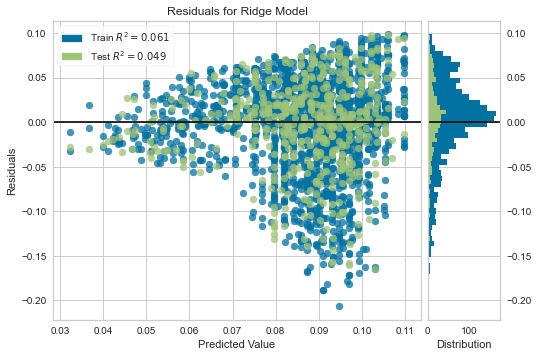

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [45]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot


# Instantiate the linear model and visualizer
model_ridge = Ridge()
visualizer = ResidualsPlot(model_ridge)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

In [46]:
y_train_ridge = model_ridge.predict(X_train)
y_test_ridge = model_ridge.predict(X_test)

In [47]:
import math

#Root mean square error.
tr_rmse = math.sqrt(mean_squared_error(y_train_ridge,y_train))
te_rmse = math.sqrt(mean_squared_error(y_test_ridge,y_test))
print("Root mean square error (RMSE):")
print("Training Set: {:.3f} ".format(tr_rmse))
print("Test Set: {:.3f} ".format(te_rmse))


Root mean square error (RMSE):
Training Set: 0.051 
Test Set: 0.049 


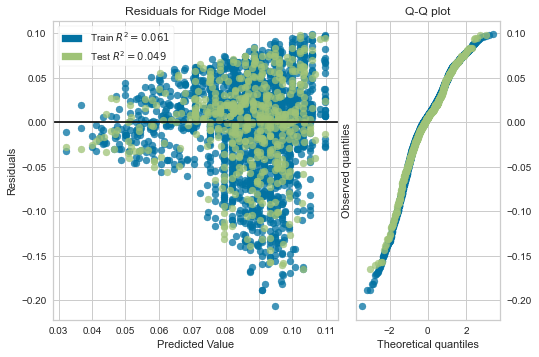

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [48]:
visualizer = ResidualsPlot(model_ridge, hist=False, qqplot=True)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

# Random Forest

In [56]:
# Grid search - tuning hyperparameters of the random forest classifier
rndfor_rdkit = RandomForestRegressor(random_state = 42)
rndfor_rdkit.fit(X_raw, y)


RandomForestRegressor(random_state=42)

In [57]:
#Hyperparameter Grid 
parameter_grid = {'max_depth':[2, 4, 6,8, 10, 50],
'n_estimators':[10, 50, 100, 150, 250]}

#Cross-Validated Grid Search
#we're now ready to create our grid-search object. We'll use each the objects we've created thus far.
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(cv=3,
estimator=rndfor_rdkit ,
param_grid=parameter_grid )

In [58]:
#fit the model
grid_search.fit(X_raw, y)


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 50],
                         'n_estimators': [10, 50, 100, 150, 250]})

In [59]:
# Visualise the accuracy score
pd.DataFrame(grid_search.cv_results_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017835,0.001749,0.003314,0.001076,2,10,"{'max_depth': 2, 'n_estimators': 10}",0.330507,0.160062,0.416563,0.302377,0.106589,13
1,0.073503,0.004254,0.005846,0.000234,2,50,"{'max_depth': 2, 'n_estimators': 50}",0.335361,0.169419,0.420659,0.308480,0.104315,10
2,0.148336,0.019256,0.009537,0.000149,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.336252,0.169761,0.424648,0.310220,0.105672,7
3,0.211518,0.024145,0.012527,0.000187,2,150,"{'max_depth': 2, 'n_estimators': 150}",0.335900,0.169181,0.423668,0.309583,0.105547,9
4,0.356989,0.028264,0.022718,0.001803,2,250,"{'max_depth': 2, 'n_estimators': 250}",0.336075,0.169438,0.424014,0.309843,0.105572,8
5,0.023092,0.002352,0.003549,0.000638,4,10,"{'max_depth': 4, 'n_estimators': 10}",0.420106,0.221833,0.418791,0.353577,0.093158,5
6,0.094625,0.008697,0.005895,0.000365,4,50,"{'max_depth': 4, 'n_estimators': 50}",0.407169,0.229695,0.438810,0.358558,0.092031,4
7,0.172303,0.011043,0.009602,0.000131,4,100,"{'max_depth': 4, 'n_estimators': 100}",0.414959,0.230397,0.443629,0.362995,0.094489,2
8,0.252984,0.020609,0.013294,0.000361,4,150,"{'max_depth': 4, 'n_estimators': 150}",0.416518,0.229596,0.440943,0.362352,0.094401,3
9,0.457621,0.031567,0.021845,0.001161,4,250,"{'max_depth': 4, 'n_estimators': 250}",0.416466,0.229008,0.446319,0.363931,0.096180,1


In [60]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 4, 'n_estimators': 250}
0.3639308653912164


In [62]:
descriptors_list = []
values_list = []
for name, imp in zip(X_raw.columns, rndfor_rd.feature_importances_):
    
    descriptors_list.append(name)
    values_list.append(round(imp,5))
    #get pairs of elements
    zip_iterator = zip(descriptors_list, values_list)


    #convert to dictionary
    dict_descriptors = dict(zip_iterator)


print(dict_descriptors)

{'CH4_flow': 0.0, 'O2_flow': 0.043, 'Ar_flow': 0.0, 'Temp': 0.94905, 'CH4/O2': 0.0, 'BET_surface_area': 0.0, 'M1_mol%': 0.0, 'M2_mol%': 0.0, 'M3_mol%': 0.0, 'M1_atom_number': 0.0, 'M2_atom_number': 0.0, 'M3_atom_number': 0.0, 'radii_M1': 0.0, 'radii_M2': 0.0, 'radii_M3': 0.0, 'chi_M1': 0.00795, 'chi_M2': 0.0, 'chi_M3': 0.0}


In [63]:
# Table of descriptors in descending order of relative importance
import operator
order = sorted(dict_descriptors.items(),key=operator.itemgetter(1),reverse=True)
order

[('Temp', 0.94905),
 ('O2_flow', 0.043),
 ('chi_M1', 0.00795),
 ('CH4_flow', 0.0),
 ('Ar_flow', 0.0),
 ('CH4/O2', 0.0),
 ('BET_surface_area', 0.0),
 ('M1_mol%', 0.0),
 ('M2_mol%', 0.0),
 ('M3_mol%', 0.0),
 ('M1_atom_number', 0.0),
 ('M2_atom_number', 0.0),
 ('M3_atom_number', 0.0),
 ('radii_M1', 0.0),
 ('radii_M2', 0.0),
 ('radii_M3', 0.0),
 ('chi_M2', 0.0),
 ('chi_M3', 0.0)]

In [64]:
descriptors = []
importance = []
for i in order:
    importance.append(i[1])
    descriptors.append(i[0])
importance[0:11]

[0.94905, 0.043, 0.00795, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

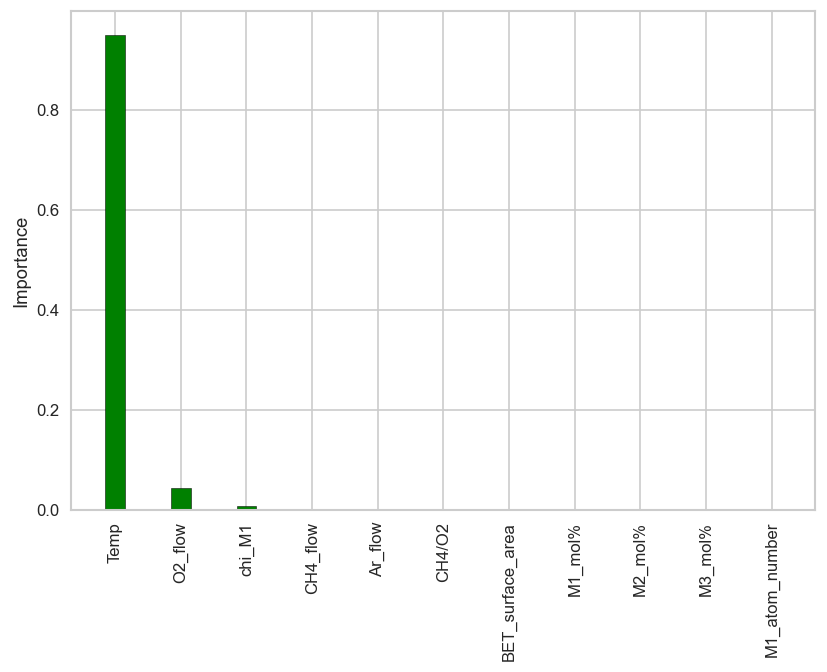

In [65]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
desc = descriptors[0:11]
imp = importance[0:11]


x = np.arange(11)  # the label locations
width = 0.30  # the width of the bars


fig, ax = plt.subplots(1,1,  dpi=120)
impo = ax.bar(x , imp, width, color = 'green', edgecolor= 'black')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Descriptors')
ax.set_ylabel('Importance')
ax.set_aspect('auto')
#ax.set_ylim(0,0.9)
#ax.set_xticks(x, labels)
ax.set_xticks( x, desc,rotation=90,)





#fig.tight_layout()

plt.show()

In [74]:
X_rf = result[[   "Temp",  "O2_flow"]].to_numpy()
y = result["rate_constant"].to_numpy()

In [75]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = sklearn.model_selection.train_test_split(X_rf, y, test_size=0.20, random_state=42)
X_train_rf.shape, X_test_rf.shape, y_train_rf.shape, y_test_rf.shape


((2186, 2), (547, 2), (2186,), (547,))

In [76]:
# From the cell above we decided to use max_depth: 4 and  n_estimators: 250

rndfor_rd = RandomForestRegressor(n_estimators=250, max_depth = 4)
rndfor_rd.fit(X_rf, y)

RandomForestRegressor(max_depth=4, n_estimators=250)

In [77]:
y_rndfor_train = rndfor_rd.predict(X_train_rf)
y_rndfor_test  = rndfor_rd.predict(X_test_rf)

In [78]:
import math
from sklearn.metrics import  mean_squared_error


#Root mean square error.
tr_rmse = math.sqrt(mean_squared_error(y_train_rf, y_rndfor_train))
te_rmse = math.sqrt(mean_squared_error(y_test_rf,y_rndfor_test))

print("Root mean square error (RMSE):")
print("Training Set: {:.3f} ".format(tr_rmse))
print("Test Set: {:.3f} ".format(te_rmse))


Root mean square error (RMSE):
Training Set: 0.039 
Test Set: 0.037 


['$Training \\: set$', '$Test Set$']


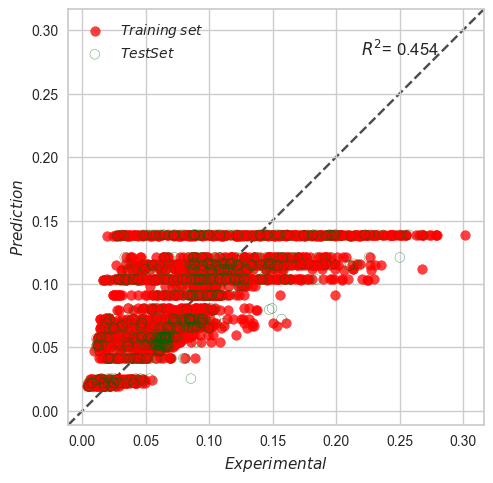

In [79]:
fig, ax = plt.subplots(1,1,  dpi=100)
ax.scatter(y_train_rf, y_rndfor_train,color='red',alpha=0.75,label='$Training \: set$')
ax.scatter(y_test_rf, y_rndfor_test,color='darkgreen',alpha=0.75,label='$Test Set$',facecolors='none')

# Find limits for each axes 
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]

ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')

ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel('$Experimental$')
ax.set_ylabel('$Prediction$')

ax.annotate('$R^{2}$'+ '= {:.3f}'.format(r2_score(y_test_rf,y_rndfor_test)), (0.22,0.28))
handles, labels = ax.get_legend_handles_labels()
print(labels)
ax.legend(handles=handles, labels=labels)

# Symbolic Regression
Once you have collected these features, we can use symbolic regression to automatically identify the most probably features and associated correlation to the kinetic rate coefficient. This will tell us what features are most important for the hydrogenation reaction and how to better design catalysts in future.

# PySR - finding the 'best' model

In [80]:
#model.reset() #we need to re-initialise the model if something went wrong previosuly 
#feel free to comment it out

In [81]:
from pysr import PySRRegressor
model = PySRRegressor(
    
    populations = 100,
    niterations= 100,
    binary_operators=["+", "*", "-", "/"],
    unary_operators=[  "cube", "square", "neg",# Custom operator (julia syntax)
    ],
    model_selection="best",
    denoise = True,
    annealing = True                               #loss function: mean squared error 
   

)

In [82]:
model.fit(X_train, y_train)

  Activating project at `~/.julia/environments/pysr-0.8.5`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pysr-0.8.5/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.8.5/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/pysr-0.8.5/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.8.5/Manifest.toml`
  No Changes to `~/.julia/environments/pysr-0.8.5/Project.toml`
  No Changes to `~/.julia/environments/pysr-0.8.5/Manifest.toml`


Started!

Cycles per second: 4.180e+04
Head worker occupation: 20.1%
Progress: 116 / 10000 total iterations (1.160%)
Hall of Fame:
-----------------------------------------
Complexity  loss       Score     Equation
1           1.366e-03  8.512e-08  0.08666608
3           1.351e-03  5.604e-03  (0.08258609 / x3)
5           1.329e-03  7.979e-03  ((0.0469526 / x3) - -0.03771653)
6           1.328e-03  9.686e-04  ((0.027425278 / square(x3)) + 0.056402966)
10          1.327e-03  1.945e-04  square(square((-1.2275735 - (0.115586855 / square(x3))) / 2.4988937))
15          1.325e-03  3.365e-04  ((cube(neg(neg(cube(0.37494615 / x3) + -0.4053192) - 0.72505724)) - -0.033897083) / 1.0365661)
17          1.322e-03  1.006e-03  (((square((0.34288248 * -0.7764498) - ((-0.00033584802 * x0) / cube(x3))) / x3) / 0.3991425) / 2.1263065)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 4.420e+04
Head worker occupation: 12.8%
Progress: 246 / 10000 total iterations (2.460%)
Hall of Fa

KeyboardInterrupt: <PyCall.jlwrap (in a Julia function called from Python)
JULIA: InterruptException:
Stacktrace:
  [1] poptask(W::Base.InvasiveLinkedListSynchronized{Task})
    @ Base ./task.jl:827
  [2] wait()
    @ Base ./task.jl:836
  [3] uv_write(s::Base.PipeEndpoint, p::Ptr{UInt8}, n::UInt64)
    @ Base ./stream.jl:992
  [4] unsafe_write(s::Base.PipeEndpoint, p::Ptr{UInt8}, n::UInt64)
    @ Base ./stream.jl:1064
  [5] write
    @ ./strings/io.jl:244 [inlined]
  [6] print(io::Base.PipeEndpoint, s::String)
    @ Base ./strings/io.jl:246
  [7] print(xs::String)
    @ Base ./coreio.jl:3
  [8] _EquationSearch(::SymbolicRegression.CoreModule.ProgramConstantsModule.SRThreaded, datasets::Vector{SymbolicRegression.CoreModule.DatasetModule.Dataset{Float32}}; niterations::Int64, options::Options{Tuple{typeof(+), typeof(*), typeof(-), typeof(/)}, Tuple{typeof(cube), typeof(square), typeof(neg)}, Nothing, Nothing, L2DistLoss, Int64}, numprocs::Int64, procs::Nothing, runtests::Bool, saved_state::Nothing, addprocs_function::Nothing)
    @ SymbolicRegression ~/.julia/packages/SymbolicRegression/Rkg8X/src/SymbolicRegression.jl:954
  [9] EquationSearch(datasets::Vector{SymbolicRegression.CoreModule.DatasetModule.Dataset{Float32}}; niterations::Int64, options::Options{Tuple{typeof(+), typeof(*), typeof(-), typeof(/)}, Tuple{typeof(cube), typeof(square), typeof(neg)}, Nothing, Nothing, L2DistLoss, Int64}, numprocs::Int64, procs::Nothing, multithreading::Bool, runtests::Bool, saved_state::Nothing, addprocs_function::Nothing)
    @ SymbolicRegression ~/.julia/packages/SymbolicRegression/Rkg8X/src/SymbolicRegression.jl:325
 [10] EquationSearch(X::Matrix{Float32}, y::Matrix{Float32}; niterations::Int64, weights::Nothing, varMap::Vector{String}, options::Options{Tuple{typeof(+), typeof(*), typeof(-), typeof(/)}, Tuple{typeof(cube), typeof(square), typeof(neg)}, Nothing, Nothing, L2DistLoss, Int64}, numprocs::Int64, procs::Nothing, multithreading::Bool, runtests::Bool, saved_state::Nothing, addprocs_function::Nothing)
    @ SymbolicRegression ~/.julia/packages/SymbolicRegression/Rkg8X/src/SymbolicRegression.jl:269
 [11] #EquationSearch#21
    @ ~/.julia/packages/SymbolicRegression/Rkg8X/src/SymbolicRegression.jl:294 [inlined]
 [12] invokelatest(::Any, ::Any, ::Vararg{Any}; kwargs::Base.Pairs{Symbol, Any, NTuple{8, Symbol}, NamedTuple{(:weights, :niterations, :varMap, :options, :numprocs, :multithreading, :saved_state, :addprocs_function), Tuple{Nothing, Int64, Vector{String}, Options{Tuple{typeof(+), typeof(*), typeof(-), typeof(/)}, Tuple{typeof(cube), typeof(square), typeof(neg)}, Nothing, Nothing, L2DistLoss, Int64}, Int64, Bool, Nothing, Nothing}}})
    @ Base ./essentials.jl:718
 [13] _pyjlwrap_call(f::Function, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall ~/.julia/packages/PyCall/7a7w0/src/callback.jl:32
 [14] pyjlwrap_call(self_::Ptr{PyCall.PyObject_struct}, args_::Ptr{PyCall.PyObject_struct}, kw_::Ptr{PyCall.PyObject_struct})
    @ PyCall ~/.julia/packages/PyCall/7a7w0/src/callback.jl:44>

In [83]:


model.sympy()

0.08223616 + 0.8847101/(x1 - 1.1120344*x4)

In [84]:
len(model.equations["sympy_format"])

11

In [85]:
for i in range(len(model.equations["sympy_format"])):
    print(model.sympy(i))

0.0866660800000000
0.08258609/x3
0.10090492 - 0.0010165664*x0
-0.00024558918*x0*x2 + 0.09948451
0.08223616 + 0.8847101/(x1 - 1.1120344*x4)
0.9123302/(x1 - 1.1146368*x4) + 0.077661134/x3
-0.000230778*x1 + 0.27268532 + 0.6803142/(x1 - 1.0925761*x4)
-0.0002271112*x0 - 0.0002271112*x1 + 0.27277964 + 0.6645674/(x1 - 1.0931195*x4)
-0.00022661503*x0 - 0.00022661503*x1 + 0.27267942 + 0.6404926/(x1 - 1.0918554*x4)
-0.00021814706*x0*x2 - 0.00021814706*x1 + 0.27314782 + 0.7152059/(x1 - 1.0943543*x4)
-0.00022350423*x0*x2 - 0.00022350423*x1 + 0.2773985 + 0.75017923/(x1 + 1.1019461*x2 - 1.1019461*x4)


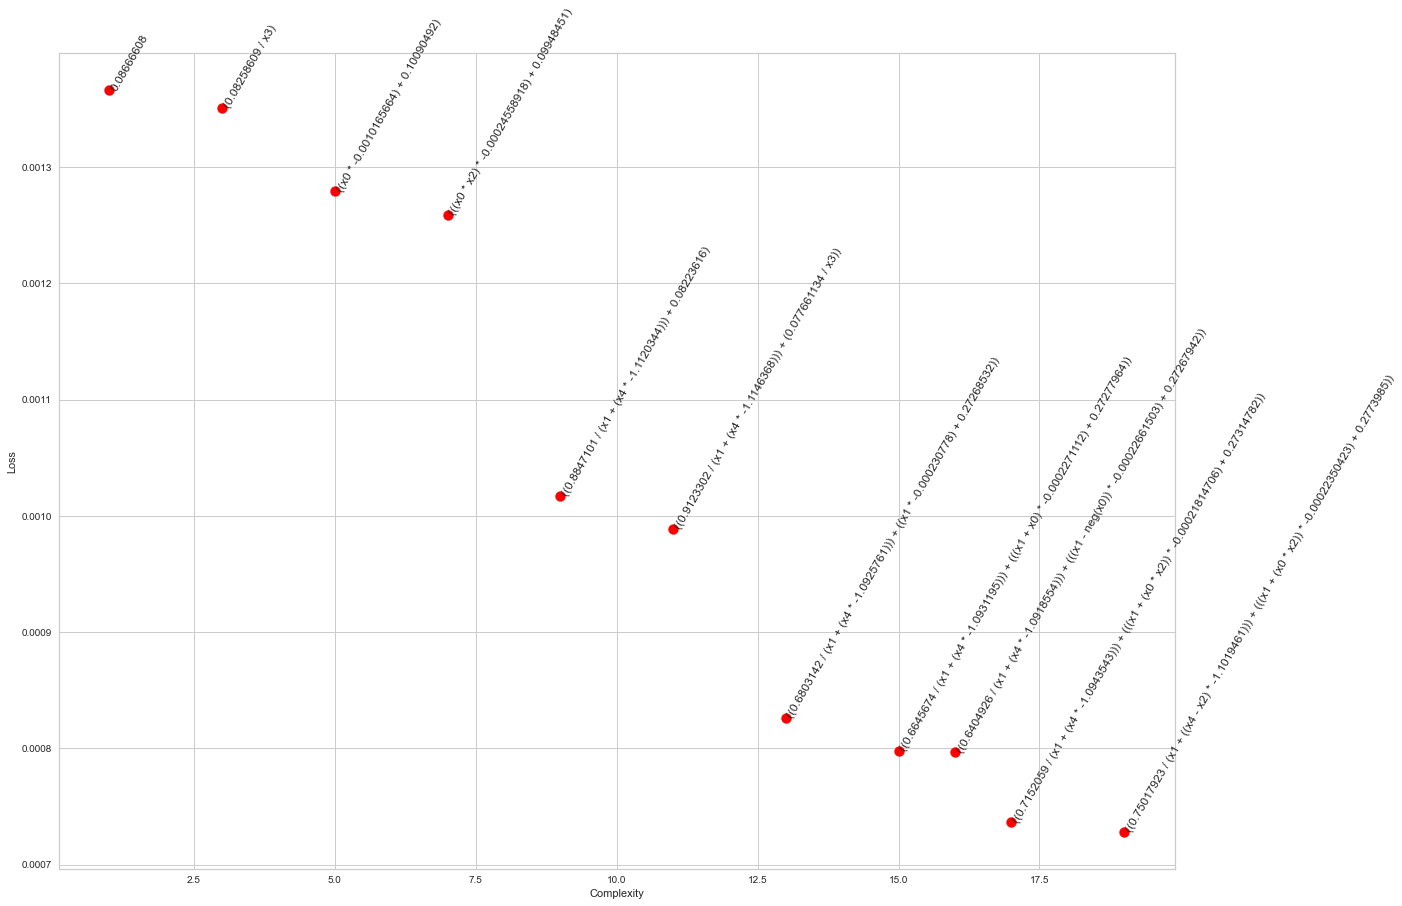

In [86]:
X = model.equations["complexity"]
Y = model.equations["loss"]
equations = model.equations["equation"].tolist()
plt.figure(figsize=(20,15))
p = plt.scatter(X,Y,s=100,color="red")
plt.xlabel("Complexity")
plt.ylabel("Loss")
plt.xlim([0, 28])
#plt.ylim([0,0.00001])

for i, label in enumerate(equations):
    plt.annotate(label, (X[i], Y[i])).set_rotation(60)

plt.axis('auto')



plt.show()


In [87]:
model.sympy()

0.08223616 + 0.8847101/(x1 - 1.1120344*x4)

In [88]:
y_pysr_train_1 = model.set_params(extra_sympy_mappings={'inv': lambda x: 1 / x}).predict(X_train)
y_pysr_test_1  = model.set_params(extra_sympy_mappings={'inv': lambda x: 1 / x}).predict(X_test)

In [89]:
X_train

array([[ 11.  , 750.  ,   6.  ,   0.93,   1.5 ],
       [  3.  , 800.  ,   6.  ,   0.98, 650.  ],
       [ 26.  , 700.  ,   3.  ,   1.83, 650.  ],
       ...,
       [ 20.  , 750.  ,   6.  ,   1.  , 650.  ],
       [  3.  , 900.  ,   2.  ,   0.98, 650.  ],
       [ 11.  , 700.  ,   2.  ,   0.93,   3.9 ]])

In [90]:
y_pysr_train_1 = model.predict(X_train)
y_pysr_test_1  = model.predict(X_test)

In [91]:
import math
from sklearn.metrics import  mean_squared_error
from sklearn.metrics import r2_score

#Root mean square error.
tr_rmse = math.sqrt(mean_squared_error(y_train, y_pysr_train_1))
te_rmse = math.sqrt(mean_squared_error(y_test, y_pysr_test_1))

tr_r2 = r2_score(y_train, y_pysr_train_1)
te_r2 = r2_score(y_test, y_pysr_test_1)
print("Root mean square error (RMSE):")
print("Training Set: {:.3f} ".format(tr_rmse))
print("Test Set: {:.3f} ".format(te_rmse))
print("R2 Scores:")
print("Training Set: {:.3f} ".format(tr_r2))
print("Test Set: {:.3f} ".format(te_r2))

Root mean square error (RMSE):
Training Set: 0.049 
Test Set: 0.047 
R2 Scores:
Training Set: 0.124 
Test Set: 0.137 


['$Training \\: set$', '$Test Set$']


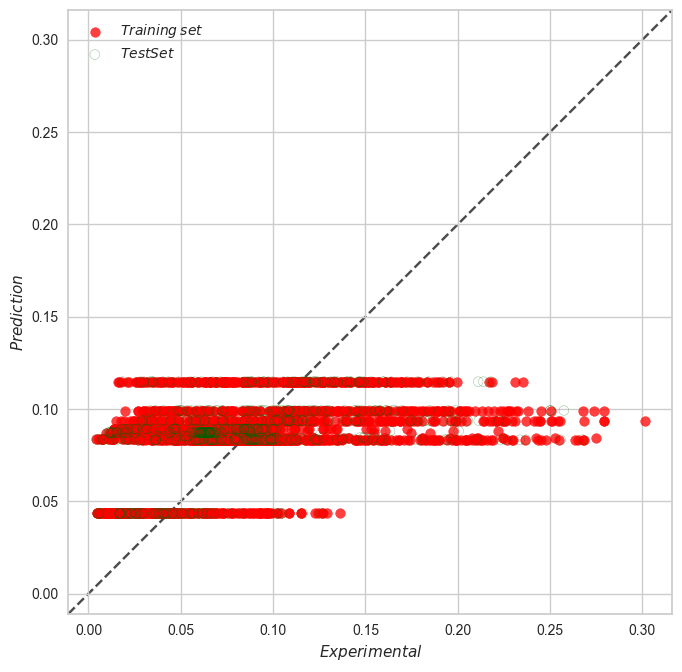

In [92]:
fig, ax = plt.subplots(1,1, figsize=(8,8), dpi=100)
ax.scatter(y_train, y_pysr_train_1,color='red',alpha=0.75,label='$Training \: set$')
ax.scatter(y_test, y_pysr_test_1,color='darkgreen',alpha=0.5,label='$Test Set$',facecolors='none')

# Find limits for each axes 
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]

ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')

ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel('$Experimental$')
ax.set_ylabel('$Prediction$')

ax.annotate('$R^{2}$'+ '= {:.3f}'.format(r2_score(y_test, y_pysr_test_1)), (0.25,0.32))
handles, labels = ax.get_legend_handles_labels()
print(labels)
ax.legend(handles=handles, labels=labels)


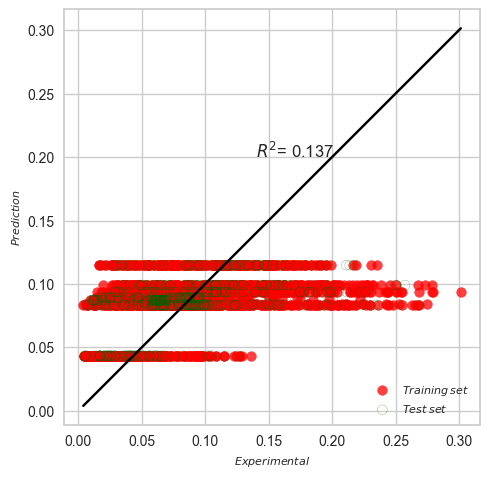

In [93]:
#parity plot 
plt.figure(dpi=100)
plt.xlabel('$Experimental$',fontsize=8)
plt.ylabel('$Prediction$',fontsize=8)
x = np.linspace(min(y_train), max(y_train), 1000)
plt.plot(x, x+0, 'black')
plt.scatter(y_train, y_pysr_train_1,color='red',alpha=0.75,label='$Training \: set$')
plt.scatter(y_test, y_pysr_test_1,color='darkgreen',alpha=0.5,label='$Test \: set$',facecolors='none')
plt.legend(fontsize=8,loc=4)
plt.annotate('$R^{2}$'+ '= {:.3f}'.format(r2_score(y_test, y_pysr_test_1)), (0.14, 0.20))
plt.axis('square')
plt.show()

In [94]:
#X_raw = result[["M1_atom_number", "M2_atom_number", "M3_atom_number", "BET_surface_area", "Temp", "Ar_flow", "CH4_flow", "O2_flow", "CH4/O2", "M1_mol%", "M2_mol%", "M3_mol%", "radii_M1", "radii_M2", "radii_M3", "chi_M1", "chi_M2", "chi_M3" ]]
X_raw = result[[ "Support ",  "CH4_flow", "O2_flow", "Ar_flow", "CH4/O2", "CT",  "Temp", "BET_surface_area", "M1_atom_number", "M2_atom_number", "M3_atom_number",  "radii_M1", "radii_M2", "radii_M3", "chi_M1", "chi_M2", "chi_M3" ]]
X_raw.describe()

,CH4_flow,O2_flow,Ar_flow,CH4/O2,CT,Temp,BET_surface_area,M1_atom_number,M2_atom_number,M3_atom_number,radii_M1,radii_M2,radii_M3,chi_M1,chi_M2,chi_M3
count,2733.000000,2733.000000,2733.000000,2733.000000,2733.00,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000,2733.000000
mean,4.491218,1.350457,4.166667,3.748262,0.75,795.901939,489.442371,30.901207,14.052689,69.796561,1.471405,1.655488,1.609491,1.567387,0.980842,1.760424
std,1.779373,0.669185,2.248868,1.478841,0.00,65.214764,267.903422,11.978160,9.355873,10.811287,0.211750,0.182492,0.027028,0.230404,0.192803,0.155412
min,2.000000,0.400000,1.500000,2.000000,0.75,700.000000,1.500000,22.000000,3.000000,42.000000,1.220000,1.220000,1.540000,1.100000,0.820000,1.700000
25%,2.400000,0.900000,1.500000,2.000000,0.75,750.000000,300.000000,25.000000,11.000000,74.000000,1.390000,1.660000,1.620000,1.550000,0.930000,1.700000
50%,4.500000,1.200000,4.000000,3.000000,0.75,800.000000,650.000000,25.000000,11.000000,74.000000,1.390000,1.660000,1.620000,1.550000,0.930000,1.700000
75%,5.700000,2.000000,7.000000,4.000000,0.75,850.000000,650.000000,29.000000,11.000000,74.000000,1.390000,1.660000,1.620000,1.550000,0.930000,1.700000
max,7.300000,2.800000,7.000000,6.000000,0.75,900.000000,650.000000,72.000000,56.000000,74.000000,2.070000,2.150000,1.620000,2.200000,1.830000,2.160000


In [95]:
result.head()

,Name,M1,M1_atom_number,M2,M2_atom_number,M3,M3_atom_number,Support,Support_ID,M2_mol,M3_mol,M1_mol%,M2_mol%,M3_mol%,Temp,Total_flow,Ar_flow,CH4_flow,O2_flow,CT,CH4/O2,CH4_conv,C2y,C2H6y,C2H4y,COy,CO2y,C2s,C2H6s,C2H4s,COs,CO2s,BET_surface_area,rate_constant,radii_M1,radii_M2,radii_M3,chi_M1,chi_M2,chi_M3
0,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,10,1.5,5.7,2.8,0.75,2,36.28,5.86,0.68,5.18,30.82,6.01,16.15,1.87,14.28,84.95,16.57,5.2,0.080516,1.39,1.66,1.62,1.55,0.93,1.7
3,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,10,1.5,6.4,2.1,0.75,3,24.47,6.16,0.62,5.54,22.49,3.00,25.17,2.53,22.64,91.91,12.26,5.2,0.084772,1.39,1.66,1.62,1.55,0.93,1.7
6,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,10,1.5,6.8,1.7,0.75,4,18.44,6.06,0.56,5.50,17.03,1.84,32.86,3.04,29.83,92.35,9.98,5.2,0.083352,1.39,1.66,1.62,1.55,0.93,1.7
9,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,10,1.5,7.3,1.2,0.75,6,18.40,5.63,0.56,5.07,11.85,0.92,30.60,3.04,27.55,64.40,5.00,5.2,0.077263,1.39,1.66,1.62,1.55,0.93,1.7
12,Mn-Na2WO4/BN,Mn,25.0,Na,11.0,W,74.0,BN,4,0.37,0.185,40.0,40.0,20.0,900,10,4.0,4.0,2.0,0.75,2,37.29,5.66,0.68,4.98,32.66,5.38,15.18,1.82,13.35,87.58,14.43,5.2,0.077687,1.39,1.66,1.62,1.55,0.93,1.7


In [97]:
OCM_new = result[[ "M2_atom_number","Temp", "CH4/O2", "chi_M2", "BET_surface_area", "rate_constant"]]


In [98]:
import feyn

ql = feyn.QLattice()

This version of feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at `https://abzu.ai/privacy`.


In [99]:

train, test = train_test_split(OCM_new, test_size=0.2, random_state=42)

In [100]:
# Instantiate a QLattice
ql = feyn.QLattice(random_seed=42)

# Sample and fit models
models = ql.auto_run(
    data=train,
    output_name='rate_constant',
    kind='regression',

)


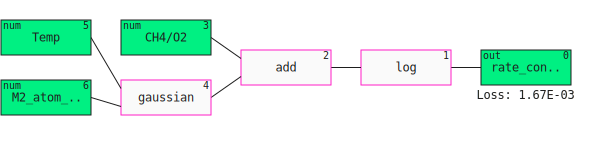

In [101]:
models[0]

In [102]:
models[0].sympify()

0.0974927*log(-0.0387863*CH4/O2 + exp(-0.25228*(1 - 0.113903*M2atomnumber)**2 - 249.315*(0.00128073*Temp - 1)**2) + 0.8852) + 0.0793983

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="232.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 875 232.0" width="875" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="155.0" width="591" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="481" y="50.0"><title>rate_constant
linear:
scale=0.148679
scale offset=0.000000
w=0.655727
bias=0.5340</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="71.5">rate_con..</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="59.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="483" y="59.0">out</text><line stroke="#1E1E1E" x1="451" x2="481" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="50.0"><title>log</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="71.5">log</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="59.0">1</text><line stroke="#1E1E1E" x1="331" x2="361" y1="67.5" y2="67.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="50.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="71.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="59.0">2</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="58.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="76.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><title>CH4/O2
linear:
scale=0.500000
scale offset=3.730558
w=-0.077573
bias=0.7405</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">CH4/O2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>gaussian2</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="101.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="89.0">4</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>Temp
linear:
scale=0.010000
scale offset=795.379689
w=1.429938
bias=0.2084</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">Temp</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>M2_atom_number
linear:
scale=0.037736
scale offset=14.006862
w=-1.072036
bias=-0.2115</title></rect><t
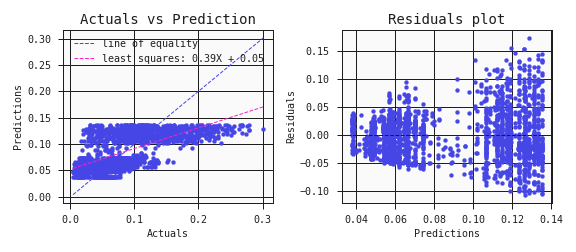
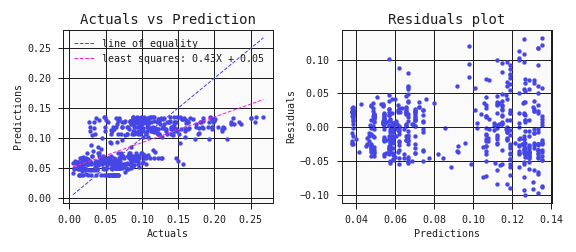

In [103]:
# Select the best Model
best = models[0]
best.plot(
    data=train,
    compare_data=test
)